# MNIST Sign Language Multi-Layer Perceptron - Pytorch

In [89]:
import numpy as np
from torchvision import transforms, datasets
import torch
import pandas as pd
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim

In [90]:
# My own custom dataset
class DriveData(torch.utils.data.Dataset):
    def __init__(self,file_path, transform = None):
        
        # load data
        self.data = pd.read_csv(file_path)
        
        self.len = len(self.data)
        
        # convert to np array
        self.label = np.asarray(self.data["label"])
        self.data = np.asarray(self.data.drop("label",axis=1))
            
    def __getitem__(self,index):
        
        # single label to be returned
        label = self.label[index]
        
        img = self.data[index].reshape(28,28).astype('uint8')
        img = Image.fromarray(img)
        
        # convert to grayscale
        img = img.convert('L')
        
        if(transform != None):
            img = transform(img)
            
        return img,label
    
    def __len__(self):
        return self.len

In [91]:
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Normalize((0.5,),(0.5,))])
# load data
train_set = DriveData("./train.csv",transform)
test_set = DriveData("./test.csv",transform)

# class size
class_size = train_set.label.max() + 1

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [92]:
# Split data into validation and training
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx = indices[split:]
valid_idx = indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 20,sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set,batch_size = 20,sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = 20)

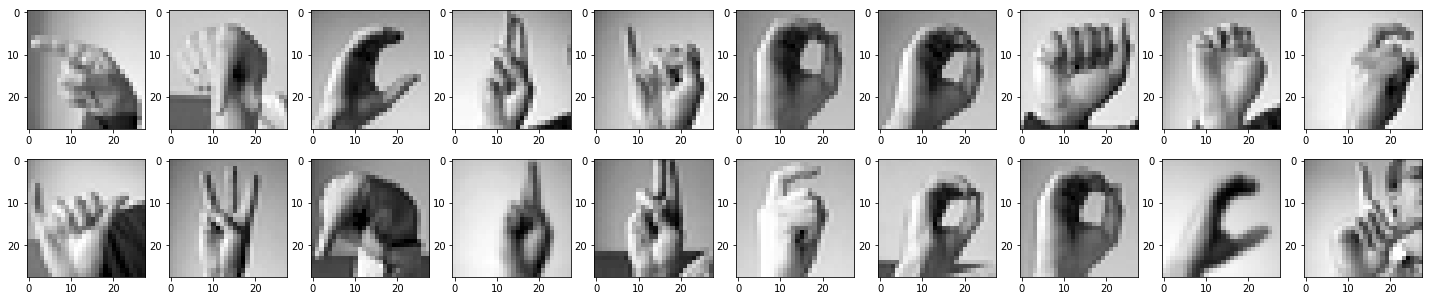

In [93]:
#visualize data

import matplotlib.pyplot as plt
%matplotlib inline

data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
fig = plt.figure(figsize=(25,5))

for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1)
    ax.imshow(np.squeeze(images[idx]),cmap = "gray")

In [94]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,class_size)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=25, bias=True)
  (dropout): Dropout(p=0.2)
  (softmax): LogSoftmax()
  (relu): ReLU()
)


In [95]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [96]:
epochs = 30

for epoch in range(epochs):
    
    valid_loss = 0.0
    train_loss = 0.0
    model.train()
    for data,label in train_loader:
        if train_on_gpu:
            data, label = data.cuda(),label.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    test_loss = 0.0
    accuracy = 0.0
    
    with torch.no_grad():
        model.eval()
        
        for data,label in valid_loader:
            if train_on_gpu:
                data, label = data.cuda(),label.cuda()
            output = model(data)
            loss = criterion(output,label)
            valid_loss += loss
        
        for data,label in test_loader:
            if train_on_gpu:
                data, label = data.cuda(),label.cuda()
            log_ps = model(data)
            test_loss += criterion(log_ps,label)
            ps = torch.exp(log_ps)
            top_p, top_c = ps.topk(1,dim=1)
            equals = top_c == label.view(*top_c.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = accuracy /len(test_loader) * 100.0
    
    print("Epoch: {} \tTraining Loss: {:.6f} \t Validation Loss {:.6f} \t Accuracy: {:.2f}%".format(
        epoch + 1,train_loss,valid_loss,accuracy))
            

Epoch: 1 	Training Loss: 3.176362 	 Validation Loss 0.153681 	 Accuracy: 16.95%
Epoch: 2 	Training Loss: 2.644200 	 Validation Loss 0.107024 	 Accuracy: 29.36%
Epoch: 3 	Training Loss: 1.961098 	 Validation Loss 0.077594 	 Accuracy: 41.43%
Epoch: 4 	Training Loss: 1.489057 	 Validation Loss 0.056228 	 Accuracy: 55.60%
Epoch: 5 	Training Loss: 1.164632 	 Validation Loss 0.041440 	 Accuracy: 63.49%
Epoch: 6 	Training Loss: 0.910548 	 Validation Loss 0.031314 	 Accuracy: 63.50%
Epoch: 7 	Training Loss: 0.719590 	 Validation Loss 0.024360 	 Accuracy: 67.37%
Epoch: 8 	Training Loss: 0.577138 	 Validation Loss 0.015342 	 Accuracy: 68.51%
Epoch: 9 	Training Loss: 0.447277 	 Validation Loss 0.011408 	 Accuracy: 68.94%
Epoch: 10 	Training Loss: 0.357321 	 Validation Loss 0.009392 	 Accuracy: 69.16%
Epoch: 11 	Training Loss: 0.282664 	 Validation Loss 0.005526 	 Accuracy: 70.54%
Epoch: 12 	Training Loss: 0.226066 	 Validation Loss 0.003788 	 Accuracy: 70.42%
Epoch: 13 	Training Loss: 0.182544 	 

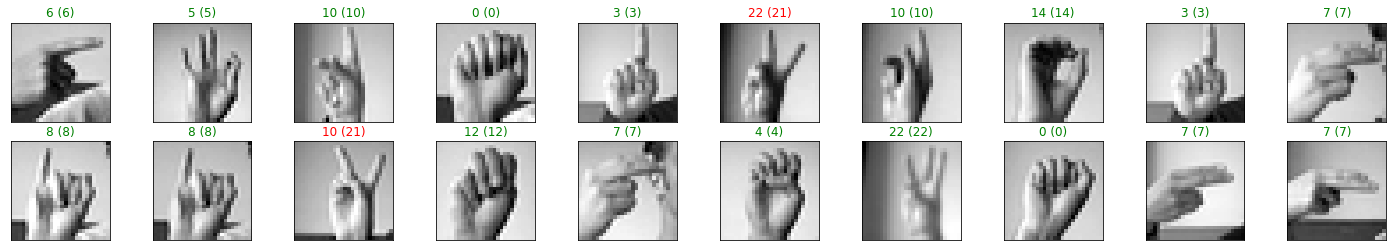

In [97]:
model.eval()
data_iter = iter(test_loader)
images, labels = data_iter.next()
output = model(images)

_, preds = torch.max(output,1)
fig = plt.figure(figsize= (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx + 1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap = "gray")
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color = ("green" if preds[idx] == labels[idx] else "red"))